In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
import os
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import warnings
warnings.filterwarnings("ignore")

### Utilities

In [3]:
def compute_track_length(df):
    squared_diff = df[df.columns[:2]].diff().fillna(0).apply(np.square)
    res = (squared_diff['x']+squared_diff['y']).apply(np.sqrt)
    return res.sum()

### Determine Track Lengths

In [4]:
racecar_walker = pd.read_csv('../../pure_pursuit/waypoints/racecar_walker_29418.csv',header=None).rename(columns={0:"x",1:"y"})
track_porto = pd.read_csv('../../pure_pursuit/waypoints/track_porto_26780.csv',header=None).rename(columns={0:"x",1:"y"})
track_barca = pd.read_csv('../../pure_pursuit/waypoints/track_barca_4676.csv',header=None).rename(columns={0:"x",1:"y"})

In [5]:
walker = compute_track_length(racecar_walker)
porto = compute_track_length(track_porto)
barca = compute_track_length(track_barca)
barca_multiplier = barca/ porto
racecar_walker_multiplier = walker/porto
print("Porto Length:",porto)
print("Walker Length:",walker)
print("Barca Length:",barca)

Porto Length: 57.492612883355136
Walker Length: 73.2483359322749
Barca Length: 221.14172044855775


In [6]:
collisions_file_str = "collisions_{}_{}.csv"
progress_file_str = "progress_{}_{}.csv"
algorithms = ["e2e","e2e_all","sac","ddpg"]
tracks = ["track_porto","track_barca","racecar_walker"]
multipliers = {"track_porto":1.0,"track_barca":barca_multiplier,"racecar_walker":racecar_walker_multiplier}

collisions_dfs = [] 
progress_dfs = []
original_dfs = []
for i in algorithms:
    for j in tracks:
        collision_path = collisions_file_str.format(i,j)
        progress_path = progress_file_str.format(i,j)
        df = pd.read_csv(progress_path).iloc[:30].rename(columns=lambda col: col.strip())
        df['Controller'] = i
        df['Track'] = (j.split("_")[1]).capitalize()
        df['laps_completed'] = df['laps_completed']*multipliers[j]
        original_dfs.append(df)
        df = df[df.columns[:2]].agg(['mean', 'median','std'])
        df['Controller'] = i
        df['Track'] = (j.split("_")[1]).capitalize()
        if(os.path.exists(collision_path)):
            c_df = pd.read_csv(collision_path).rename(columns=lambda col: col.strip())
            col_count = c_df[c_df["experiment_number"]<=30].shape[0]
            row = [[i,(j.split("_")[1]).capitalize(),col_count]]
        else:
            row = [[i,(j.split("_")[1]).capitalize(),0]]
        row_df = pd.DataFrame(row,columns=['Controller','Track','Number of Collisions'])
        collisions_dfs.append(row_df)
        progress_dfs.append(df)

In [7]:
collisions = pd.concat(collisions_dfs).reset_index().drop(columns="index")
collisions

,Controller,Track,Number of Collisions
0,e2e,Porto,0
1,e2e,Barca,5
2,e2e,Walker,30
3,e2e_all,Porto,0
4,e2e_all,Barca,0
5,e2e_all,Walker,0
6,sac,Porto,0
7,sac,Barca,30
8,sac,Walker,30
9,ddpg,Porto,0


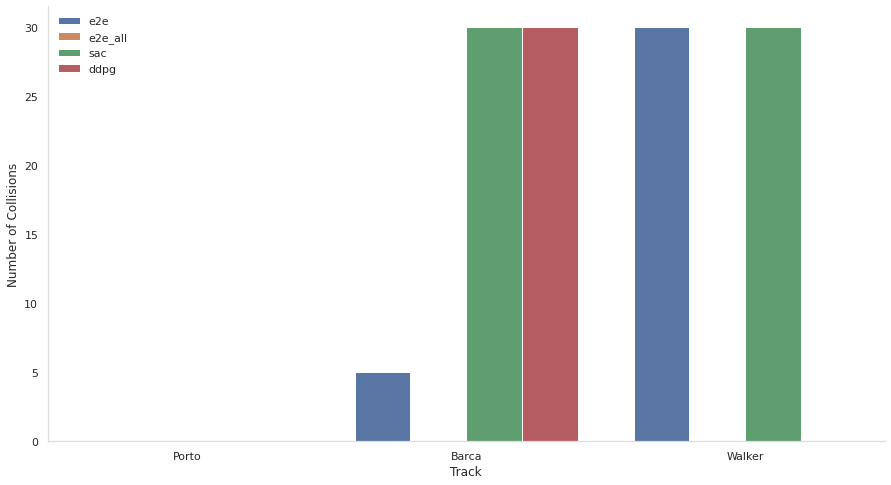

In [7]:
plt.figure(figsize=(15,8))
ax = sns.barplot(data=collisions, x="Track",y="Number of Collisions",hue="Controller")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
_= plt.legend(loc='upper left',frameon=False)

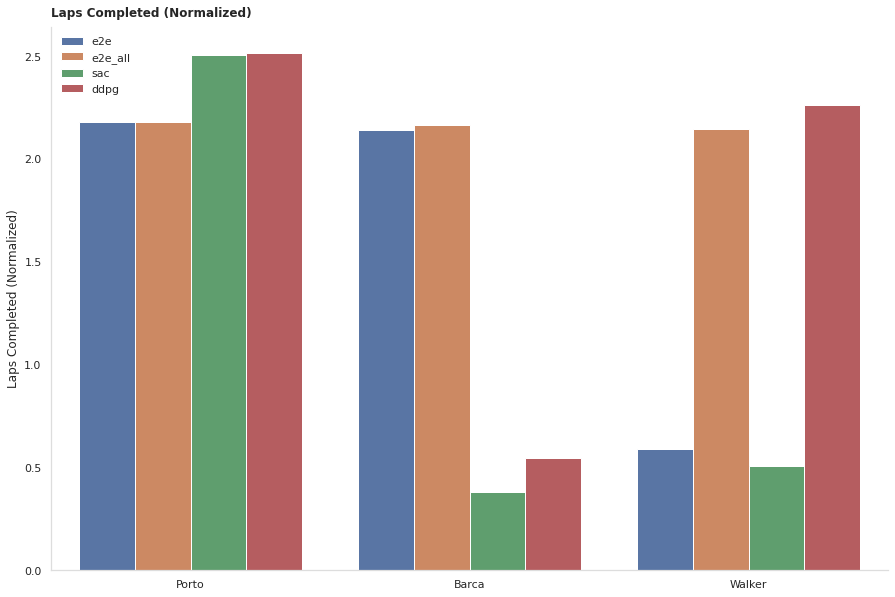

In [8]:
progress = pd.concat(progress_dfs).rename(columns={"laps_completed":"Normalized Laps Completed"})
plt.figure(figsize=(15,10))
ax = sns.barplot(data=progress[progress.index=='median'], x="Track",y="Normalized Laps Completed",hue="Controller")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
_= plt.legend(loc='upper left',frameon=False)
_= plt.ylabel('Laps Completed (Normalized)')
_= plt.xlabel('')
_= plt.title('Laps Completed (Normalized)',loc='left',pad=10.0,fontweight="bold")

In [8]:
all_dfs = pd.concat(original_dfs).rename(columns={"laps_completed":"Normalized Laps Completed"})
all_dfs

,Normalized Laps Completed,time_elapsed,experiment_number,Controller,Track
0,2.108580,62.370,1,e2e,Porto
1,2.181473,62.324,2,e2e,Porto
2,1.183751,62.324,3,e2e,Porto
3,2.178436,62.271,4,e2e,Porto
4,2.183751,62.357,5,e2e,Porto
...,...,...,...,...,...
25,2.264317,62.325,26,ddpg,Walker
26,2.255449,62.379,27,ddpg,Walker
27,2.256927,62.285,28,ddpg,Walker
28,2.259883,62.357,29,ddpg,Walker


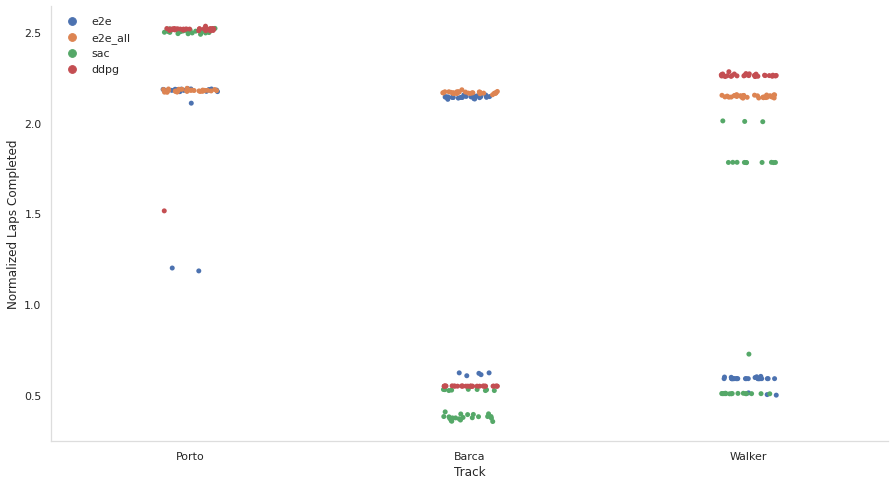

In [10]:
plt.figure(figsize=(15,8))
ax =  sns.stripplot(x="Track", y="Normalized Laps Completed", data=all_dfs,hue='Controller')
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
_= plt.legend(loc='upper left',frameon=False)

# Analysis of Varying the Speed 

In [9]:
# Experiment Parameters
algorithms = ["e2e","e2e_all","sac","ddpg"]
tracks = ["track_porto","track_barca","racecar_walker"]
speeds =  ["_0.5","","_1.5"]#["_0.5",


# file name templates
collisions_file_str = "collisions_{}_{}{}.csv"
progress_file_str = "progress_{}_{}{}.csv"
collisions_dfs = [] 
progress_dfs = []
original_dfs = []

for i in algorithms:
    for j in tracks:
        for k in speeds:
            collision_path = collisions_file_str.format(i,j,k)
            progress_path = progress_file_str.format(i,j,k)
            if(not k ):
                k="1.0"
            if(not os.path.exists(progress_path)):
                continue    
            #print('--------------------------------------------------------')
            df = pd.read_csv(progress_path).iloc[:30].rename(columns=lambda col: col.strip())
            df['Controller'] = i
            df['Track'] = (j.split("_")[1]).capitalize()
            df['Speed'] = k.replace("_","")
            df['laps_completed'] = df['laps_completed']*multipliers[j]
            original_dfs.append(df)
            df = df[df.columns[:2]].agg(['mean', 'median','std'])
            df['Controller'] = i
            df['Track'] = (j.split("_")[1]).capitalize()
            df['Speed'] = k.replace("_","")
            #print(df)
            if(os.path.exists(collision_path)):
                c_df = pd.read_csv(collision_path).rename(columns=lambda col: col.strip())
                col_count = c_df[c_df["experiment_number"]<=30].shape[0]
                row = [[i,(j.split("_")[1]).capitalize(),col_count, k.replace("_","")]]
                #print("Number of Collisions",col_count)
            else:
                row = [[i,(j.split("_")[1]).capitalize(),0, k.replace("_","")]]
                #print("Number of Collisions",0)
            row_df = pd.DataFrame(row,columns=['Controller','Track','Number of Collisions','Speed'])
            collisions_dfs.append(row_df)
            progress_dfs.append(df)
            #print('--------------------------------------------------------')

In [10]:
collisions = pd.concat(collisions_dfs).reset_index().drop(columns="index")
collisions.head()

,Controller,Track,Number of Collisions,Speed
0,e2e,Porto,0,0.5
1,e2e,Porto,0,1.0
2,e2e,Porto,2,1.5
3,e2e,Barca,0,0.5
4,e2e,Barca,5,1.0


In [13]:
pd.concat(progress_dfs)

,laps_completed,time_elapsed,Controller,Track,Speed
mean,1.125766,62.349067,e2e,Porto,0.5
median,1.126424,62.341000,e2e,Porto,0.5
std,0.006417,0.097435,e2e,Porto,0.5
mean,2.112351,62.343133,e2e,Porto,1.0
median,2.180334,62.324000,e2e,Porto,1.0
...,...,...,...,...,...
median,2.260622,62.352500,ddpg,Walker,1.0
std,0.005895,0.124566,ddpg,Walker,1.0
mean,0.486266,9.586800,ddpg,Walker,1.5
median,0.486266,9.538500,ddpg,Walker,1.5


In [11]:
progress = pd.concat(progress_dfs).rename(columns={"laps_completed":"Normalized Laps Completed"})
progress.head()

,Normalized Laps Completed,time_elapsed,Controller,Track,Speed
mean,1.125766,62.349067,e2e,Porto,0.5
median,1.126424,62.341000,e2e,Porto,0.5
std,0.006417,0.097435,e2e,Porto,0.5
mean,2.112351,62.343133,e2e,Porto,1.0
median,2.180334,62.324000,e2e,Porto,1.0


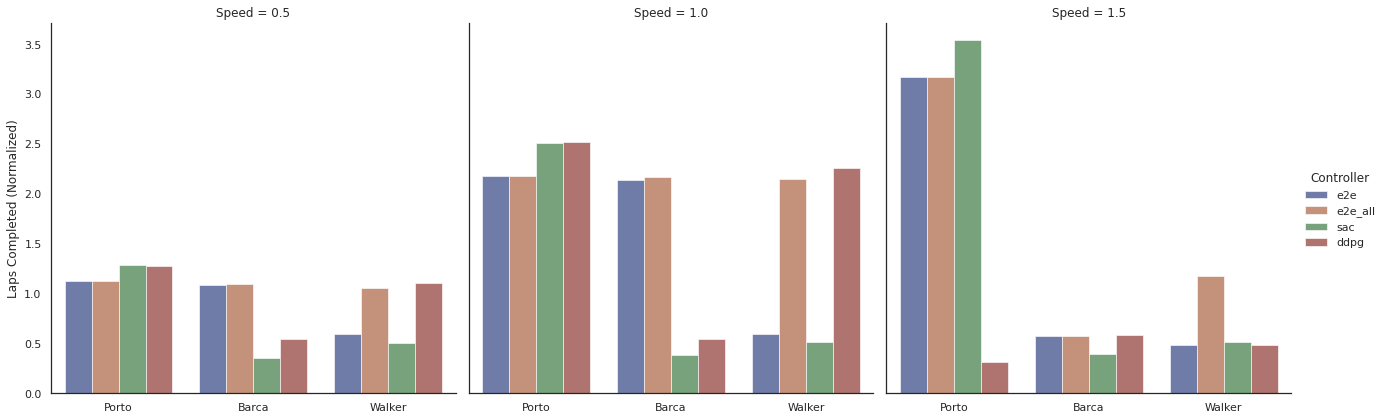

In [14]:
g = sns.catplot(
    data=progress[progress.index=='median'], kind="bar",
    x="Track", y="Normalized Laps Completed", hue="Controller", col='Speed',
    ci="sd", palette="dark", alpha=.6, height=6
)
g.set_axis_labels( "" , "Laps Completed (Normalized)" ) 
# Title for the complete figure 
#g.fig.suptitle("Laps Completed (Normalized) vs. Velocity" , 
#               va='top',
#               ha='left',
#               fontsize = 'large' ,  
#               fontweight = 'bold') 

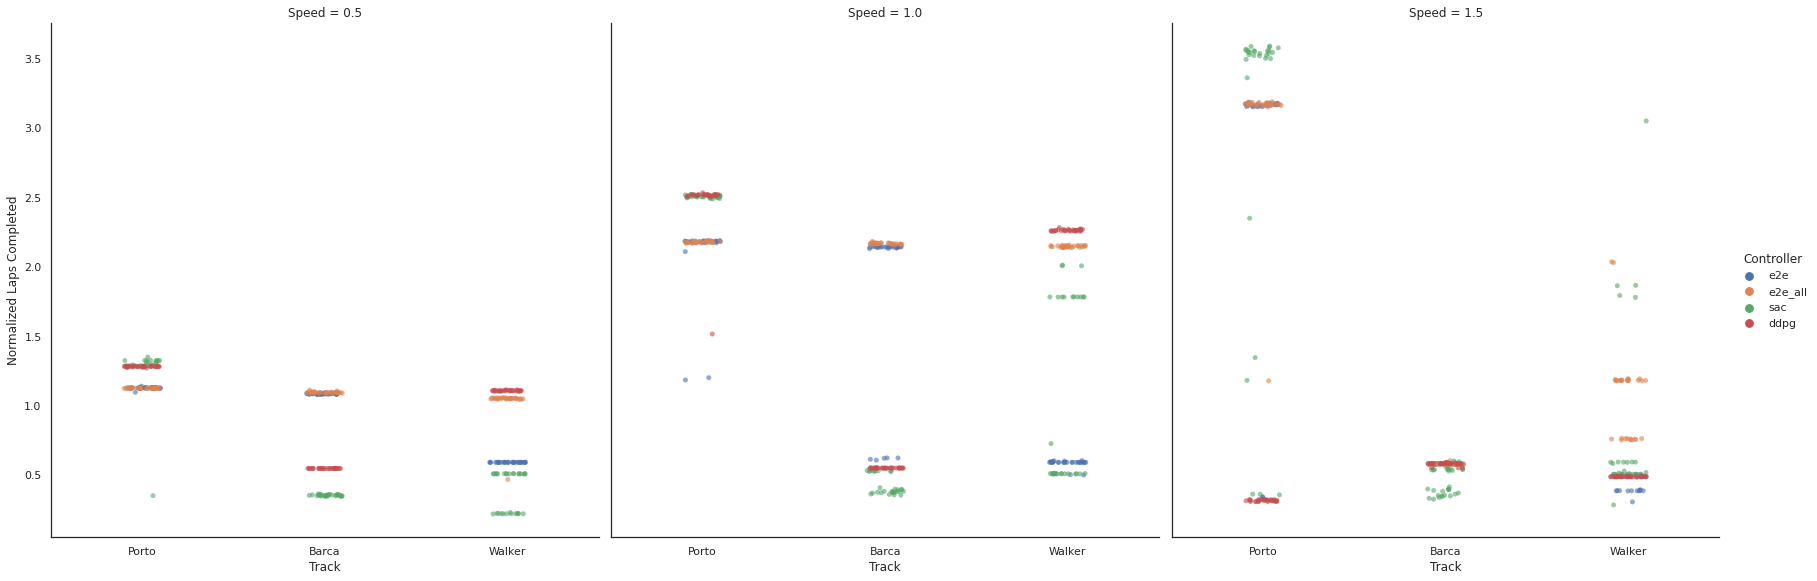

In [15]:
all_dfs = pd.concat(original_dfs).rename(columns={"laps_completed":"Normalized Laps Completed"})
g = sns.catplot(
    data=all_dfs, kind="strip",
    x="Track", y="Normalized Laps Completed", hue="Controller", col='Speed',
    ci="sd", alpha=.6, height=8, aspect = 1.0,
)

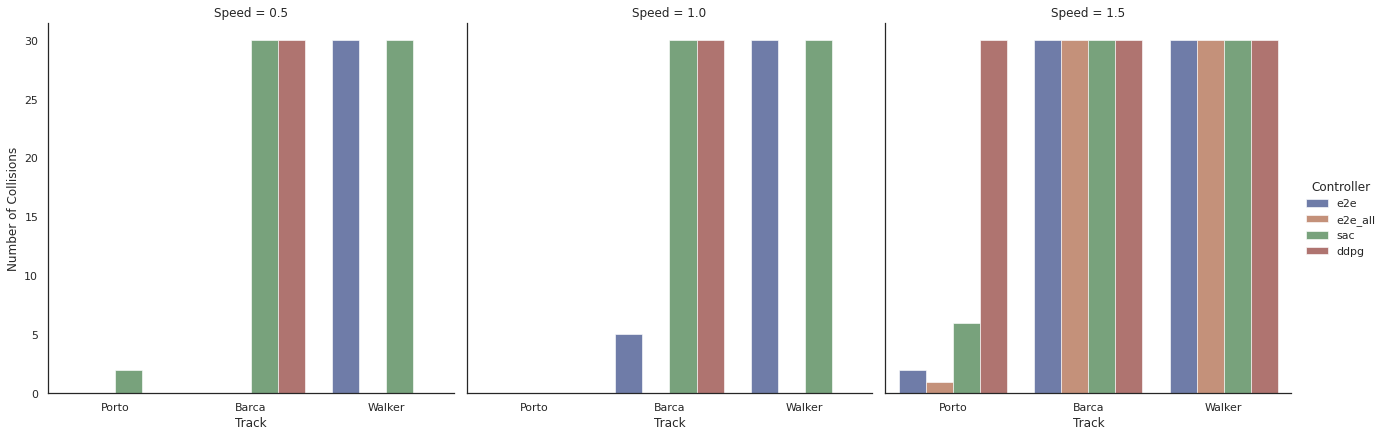

In [16]:
g = sns.catplot(
    data=collisions, kind="bar",
    x="Track", y="Number of Collisions", hue="Controller", col='Speed',
    ci="sd", palette="dark", alpha=.6, height=6, aspect = 1.0,
)

### Experiments with Cones

In [17]:
collisions_file_str = "collisions_{}_{}_1.0_cones.csv"
progress_file_str = "progress_{}_{}_1.0_cones.csv"
algorithms = ["e2e","e2e_all","sac","ddpg"]
collisions_dfs = [] 
progress_dfs = []
original_dfs = []
for i in algorithms:
    collision_path = collisions_file_str.format(i,'track_porto')
    progress_path = progress_file_str.format(i,'track_porto')
    df = pd.read_csv(progress_path).iloc[:30].rename(columns=lambda col: col.strip())
    df['Controller'] = i
    df['Track'] = "Porto"
    #df['laps_completed'] = df['laps_completed']*multipliers[j]
    original_dfs.append(df)
    df = df[df.columns[:2]].agg(['mean', 'median','std'])
    df['Controller'] = i
    df['Track'] = "Porto"
    #print(df)
    if(os.path.exists(collision_path)):
        c_df = pd.read_csv(collision_path).rename(columns=lambda col: col.strip())
        col_count = c_df[c_df["experiment_number"]<=30].shape[0]
        row = [[i,(j.split("_")[1]).capitalize(),col_count]]
        #print("Number of Collisions",col_count)
    else:
        row = [[i,(j.split("_")[1]).capitalize(),0]]
            #print("Number of Collisions",0)
    row_df = pd.DataFrame(row,columns=['Controller','Track','Number of Collisions'])
    collisions_dfs.append(row_df)
    progress_dfs.append(df)

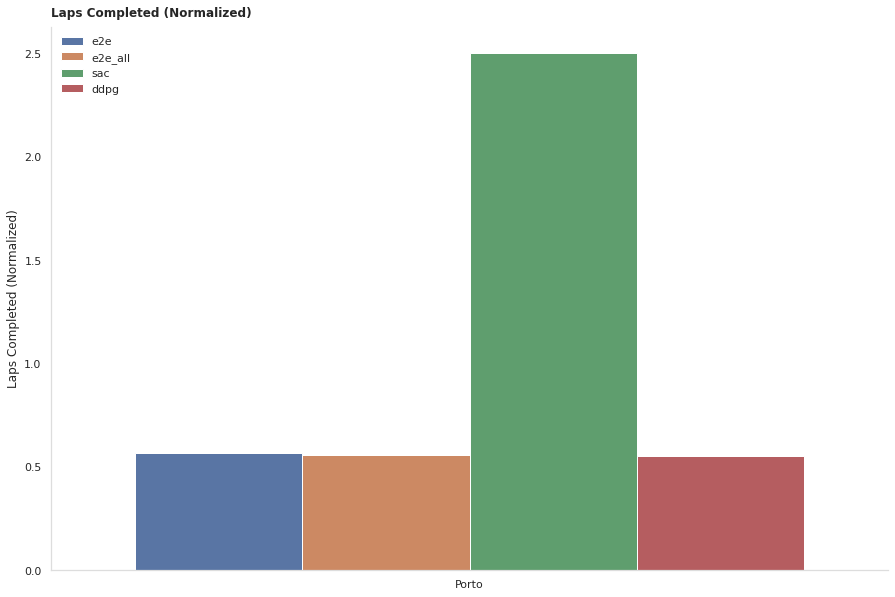

In [18]:
progress = pd.concat(progress_dfs)
progress = pd.concat(progress_dfs).rename(columns={"laps_completed":"Normalized Laps Completed"})
plt.figure(figsize=(15,10))
ax = sns.barplot(data=progress[progress.index=='median'], x="Track",y="Normalized Laps Completed",hue="Controller")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
_= plt.legend(loc='upper left',frameon=False)
_= plt.ylabel('Laps Completed (Normalized)')
_= plt.xlabel('')
_= plt.title('Laps Completed (Normalized)',loc='left',pad=10.0,fontweight="bold")

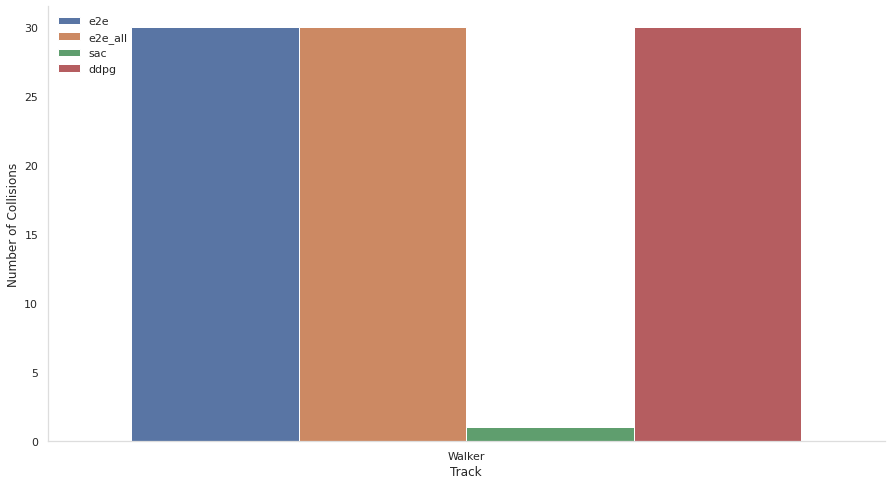

In [19]:
collisions = pd.concat(collisions_dfs).reset_index().drop(columns="index")
plt.figure(figsize=(15,8))
ax = sns.barplot(data=collisions, x="Track",y="Number of Collisions",hue="Controller")
ax.spines['bottom'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')
sns.despine(left=False, bottom=False, right=True)
_= plt.legend(loc='upper left',frameon=False)